In [ ]:
from IPython.display import clear_output

import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np


from sklearn.preprocessing import LabelEncoder

In [ ]:
# Check and set which device type is available

device = "cpu"

if torch.cuda.is_available():
  device = "cuda"

print(f"Using device: {device}")

Using device: cuda


In [ ]:
!gdown "1w2zPSfyAoSopS-BhFurKayYa_OhjI9YH"

Downloading...
From (original): https://drive.google.com/uc?id=1w2zPSfyAoSopS-BhFurKayYa_OhjI9YH
From (redirected): https://drive.google.com/uc?id=1w2zPSfyAoSopS-BhFurKayYa_OhjI9YH&confirm=t&uuid=8b629e25-8eb5-44cb-851e-1f27aeca0141
To: /content/MVSA-Single.zip
100% 211M/211M [00:02<00:00, 91.3MB/s]


In [ ]:
!unzip MVSA-Single.zip
clear_output()

In [ ]:
df = pd.read_csv("MVSA_Single/labelResultAll.csv")

# Initialize and fit the label encoder
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

In [ ]:
# Get Captions

path_to_data = "MVSA_Single/data/"
# List to store contents of all txt files
all_captions = []

# List all files in the directory
for file in os.listdir(path_to_data):
  if file.endswith(".txt"):
    # Get the full path of the file
    file_path = os.path.join(path_to_data, file)

    # Open the file and read its content
    with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
      content = f.read()

      # Append the content to the list
      all_captions.append(content)
df["captions"] = pd.DataFrame({"captions": all_captions})

In [ ]:
df.head()

,ID,label,label_encoded,captions
0,1,positive,2,Why don't dolphins fight back when their survi...
1,2,positive,2,RT @DogRescue2014: ? Foster urgently needed in...
2,3,positive,2,Happy Valentines day Ajit???????khush rehna?? \n
3,4,positive,2,https://t��\n
4,5,positive,2,RT @LoveStoneArts: Evil Eye Earrings Lampwork ...


In [ ]:
print(f"Length df: {len(df)}")

Length df: 4869


<Axes: xlabel='label'>

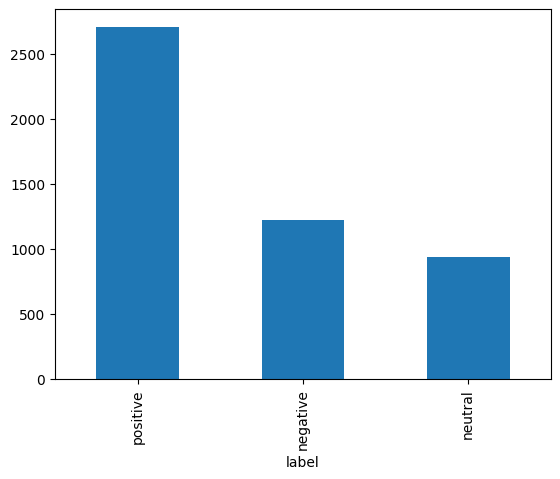

In [ ]:
df['label'].value_counts().plot(kind="bar")

In [ ]:
## retain only text that contain less that 70 tokens to avoid too much padding
df["token_size"] = df["captions"].apply(lambda x: len(x.split(' ')))
df = df.loc[df['token_size'] < 70].copy()

print(f"Length after tokenizaton and limit on 70: {len(df)}")

Length after tokenizaton and limit on 70: 4869


In [ ]:
# Create Vocabulary

class ConstructVocab():
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()

    def create_index(self):
        for s in self.sentences:
            # update with individual tokens
            self.vocab.update(s.split(' '))

        # sort the vocab
        self.vocab = sorted(self.vocab)

        # add a padding token with index 0
        self.word2idx['<pad>'] = 0

        # word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # +1 because of pad token

        # index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word

In [ ]:
## construct vocab and indexing
inputs = ConstructVocab(df["captions"].values.tolist())

## examples of what is in the vocab
inputs.vocab[0:10]

['',
 '\n',
 '!',
 '!!',
 '!!!',
 '!!!!',
 '!!!!!!',
 '!!/):&3\'wH!2@"0hGrw$]+?=_=%-$#_+\'el',
 '"',
 '""impotent""']

In [ ]:
# Convert data to tensor
input_tensor = [[inputs.word2idx[s] for s in es.split(' ')]  for es in df["captions"].values.tolist()]

In [ ]:
# Data padding

# function to find max length of batch
def max_length(tensor):
    return max(len(t) for t in tensor)

# calculate the max_length of input tensor
max_length_inp = max_length(input_tensor)
print(max_length_inp)


## padding sequences
def pad_sequences(x, max_len):
    padded = np.zeros((max_len), dtype=np.int64)
    if len(x) > max_len: padded[:] = x[:max_len]
    else: padded[:len(x)] = x
    return padded

30


In [ ]:
## inplace padding
input_tensor = [pad_sequences(x, max_length_inp) for x in input_tensor]

In [ ]:
import time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import itertools
import pandas as pd
from scipy import stats
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

## convert targets to one-hot encoding vectors
sentiments = list(set(df.label.unique()))
num_sentiments = len(sentiments)

## binarizer
mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(sens) & set(sentiments) for sens in df[['label']].values]
bin_sentiments = mlb.fit_transform(data_labels)
target_tensor = np.array(bin_sentiments.tolist())

# Split data

In [ ]:
## Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

## Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_tensor_val, input_tensor_test, target_tensor_val, target_tensor_test = train_test_split(input_tensor_val, target_tensor_val, test_size=0.5)

## Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val), len(input_tensor_test), len(target_tensor_test)

(3895, 3895, 487, 487, 487, 487)

# Dataset and DataLoader

In [ ]:
## Define a few useful parameters

TRAIN_BUFFER_SIZE = len(input_tensor_train)
VAL_BUFFER_SIZE = len(input_tensor_val)
TEST_BUFFER_SIZE = len(input_tensor_test)
BATCH_SIZE = 64

TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

In [ ]:
class MyData(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.target = y
        self.length = [ np.sum(1 - np.equal(x, 0)) for x in X]

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        x_len = self.length[index]

        return x, y, x_len

    def __len__(self):
        return len(self.data)

In [ ]:
## Dataset instance
train_dataset = MyData(input_tensor_train, target_tensor_train)
val_dataset = MyData(input_tensor_val, target_tensor_val)
test_dataset = MyData(input_tensor_test, target_tensor_test)


## Data Loader instance
train_dataset = DataLoader(train_dataset, batch_size = BATCH_SIZE,
                     drop_last=True,
                     shuffle=True)

val_dataset = DataLoader(val_dataset, batch_size = BATCH_SIZE,
                     drop_last=True,
                     shuffle=True)

test_dataset = DataLoader(test_dataset, batch_size = BATCH_SIZE,
                     drop_last=True,
                     shuffle=True)

# Solving with GRU

In [ ]:
class SentGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size):
        super().__init__()
        self.batch_sz = batch_sz
        self.hidden_units = hidden_units
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.output_size = output_size

        ## layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.dropout = nn.Dropout(p=0.5) # avoid overfitting
        self.rnn = nn.GRU(self.embedding_dim, self.hidden_units)
        self.fc = nn.Linear(self.hidden_units, self.output_size)

    def initialize_hidden_state(self):
        return torch.zeros(1, self.batch_sz, self.hidden_units)

    def forward(self, x, lens):
        x = self.embedding(x)
        self.hidden = self.initialize_hidden_state().to(x.device)
        output, self.hidden = self.rnn(x, self.hidden) # max_len X batch_size X hidden_units
        out = output[-1, :, :]
        out = self.dropout(out)
        out = self.fc(out)
        return out, self.hidden

In [ ]:
# parameters
TRAIN_BUFFER_SIZE = len(input_tensor_train)
VAL_BUFFER_SIZE = len(input_tensor_val)
TEST_BUFFER_SIZE = len(input_tensor_test)
BATCH_SIZE = 64
TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

embedding_dim = 256
units = 1024
vocab_inp_size = len(inputs.word2idx)
target_size = 3 # num_sentiments

In [ ]:
def loss_function(y, prediction):
    #CrossEntropyLoss expects outputs and class indices as target
    ## convert from one-hot encoding to class indices
    target = torch.max(y, 1)[1]
    loss = criterion(prediction, target)
    return loss

def accuracy(target, logit):
    ''' Obtain accuracy for training round '''
    target = torch.max(target, 1)[1] # convert from one-hot encoding to class indices
    corrects = (torch.max(logit, 1)[1].data == target).sum()
    accuracy = 100.0 * corrects / len(logit)
    return accuracy

In [ ]:
## Enabling cuda
model = SentGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

# Count the frequencies of each class
class_counts = df['label'].value_counts()

# Calculate inverse frequencies
inverse_frequencies = 1.0 / class_counts

# Normalize weights
normalized_weights = inverse_frequencies / inverse_frequencies.sum()

# Convert to PyTorch tensor
class_weights = torch.tensor(normalized_weights.values, dtype=torch.float)

# Define the loss criterion with weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

## loss criterion and optimizer for training
criterion = nn.CrossEntropyLoss() # the same as log_softmax + NLLLoss
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
## Enabling cuda
model = SentGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

## loss criterion and optimizer for training
criterion = nn.CrossEntropyLoss() # the same as log_softmax + NLLLoss
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    start = time.time()

    ### Initialize hidden state
    # TODO: do initialization here.
    total_loss = 0
    train_accuracy, val_accuracy = 0, 0

    ### Training
    for (batch, (inp, targ, lens)) in enumerate(train_dataset):
        loss = 0
        inp = inp.permute(1 ,0).to(device)
        predictions, _ = model(inp, lens)

        loss += loss_function(targ.to(device), predictions)
        batch_loss = (loss / int(targ.shape[1]))
        total_loss += batch_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_accuracy = accuracy(targ.to(device), predictions)
        train_accuracy += batch_accuracy

        if batch % 100 == 0:
            print('Epoch {} Batch {} Val. Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.cpu().detach().numpy()))

    ### Validating
    for (batch, (inp, targ, lens)) in enumerate(val_dataset):
        predictions,_ = model(inp.permute(1, 0).to(device), lens)
        batch_accuracy = accuracy(targ.to(device), predictions)
        val_accuracy += batch_accuracy

    print('Epoch {} Loss {:.4f} -- Train Acc. {:.4f} -- Val Acc. {:.4f}'.format(epoch + 1,
                                                             total_loss / TRAIN_N_BATCH,
                                                             train_accuracy / TRAIN_N_BATCH,
                                                             val_accuracy / VAL_N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Val. Loss 0.3595
Epoch 1 Loss 0.3590 -- Train Acc. 52.6823 -- Val Acc. 54.6875
Time taken for 1 epoch 1.2013390064239502 sec

Epoch 2 Batch 0 Val. Loss 0.3359
Epoch 2 Loss 0.3383 -- Train Acc. 54.4792 -- Val Acc. 55.8036
Time taken for 1 epoch 1.1302413940429688 sec

Epoch 3 Batch 0 Val. Loss 0.2869
Epoch 3 Loss 0.3120 -- Train Acc. 56.6927 -- Val Acc. 49.3304
Time taken for 1 epoch 1.1327180862426758 sec

Epoch 4 Batch 0 Val. Loss 0.2410
Epoch 4 Loss 0.2343 -- Train Acc. 70.7552 -- Val Acc. 43.9732
Time taken for 1 epoch 1.1700825691223145 sec

Epoch 5 Batch 0 Val. Loss 0.1640
Epoch 5 Loss 0.1317 -- Train Acc. 85.2344 -- Val Acc. 38.3929
Time taken for 1 epoch 1.1808934211730957 sec



In [ ]:
# Trying with basic RNN

class SentRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size):
        super(SentRNN, self).__init__()
        self.batch_sz = batch_sz
        self.hidden_units = hidden_units
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.output_size = output_size

        ## layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.dropout = nn.Dropout(p=0.5) # avoid overfitting
        self.rnn = nn.RNN(self.embedding_dim, self.hidden_units)
        self.fc = nn.Linear(self.hidden_units, self.output_size)

    def initialize_hidden_state(self):
        return torch.zeros(1, self.batch_sz, self.hidden_units)

    def forward(self, x, lens):
        x = self.embedding(x)
        self.hidden = self.initialize_hidden_state().to(x.device)
        output, self.hidden = self.rnn(x, self.hidden) # max_len X batch_size X hidden_units
        out = output[-1, :, :]
        out = self.dropout(out)
        out = self.fc(out)
        return out, self.hidden

In [ ]:
## Enabling cuda
model = SentRNN(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

## loss criterion and optimizer for training
criterion = nn.CrossEntropyLoss() # the same as log_softmax + NLLLoss
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    start = time.time()

    ### Initialize hidden state
    # TODO: do initialization here.
    total_loss = 0
    train_accuracy, val_accuracy = 0, 0

    ### Training
    for (batch, (inp, targ, lens)) in enumerate(train_dataset):
        loss = 0
        inp = inp.permute(1 ,0).to(device)
        predictions, _ = model(inp, lens)

        loss += loss_function(targ.to(device), predictions)
        batch_loss = (loss / int(targ.shape[1]))
        total_loss += batch_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_accuracy = accuracy(targ.to(device), predictions)
        train_accuracy += batch_accuracy

        if batch % 100 == 0:
            print('Epoch {} Batch {} Val. Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.cpu().detach().numpy()))

    ### Validating
    for (batch, (inp, targ, lens)) in enumerate(val_dataset):
        predictions,_ = model(inp.permute(1, 0).to(device), lens)
        batch_accuracy = accuracy(targ.to(device), predictions)
        val_accuracy += batch_accuracy

    print('Epoch {} Loss {:.4f} -- Train Acc. {:.4f} -- Val Acc. {:.4f}'.format(epoch + 1,
                                                             total_loss / TRAIN_N_BATCH,
                                                             train_accuracy / TRAIN_N_BATCH,
                                                             val_accuracy / VAL_N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Val. Loss 0.3475
Epoch 1 Loss 0.3761 -- Train Acc. 48.5156 -- Val Acc. 55.5804
Time taken for 1 epoch 0.627025842666626 sec

Epoch 2 Batch 0 Val. Loss 0.3155
Epoch 2 Loss 0.3544 -- Train Acc. 51.0417 -- Val Acc. 48.8839
Time taken for 1 epoch 0.6026344299316406 sec

Epoch 3 Batch 0 Val. Loss 0.3676
Epoch 3 Loss 0.3518 -- Train Acc. 51.9010 -- Val Acc. 55.8036
Time taken for 1 epoch 0.5960578918457031 sec

Epoch 4 Batch 0 Val. Loss 0.3399
Epoch 4 Loss 0.3514 -- Train Acc. 51.5885 -- Val Acc. 55.3571
Time taken for 1 epoch 0.5938575267791748 sec

Epoch 5 Batch 0 Val. Loss 0.3654
Epoch 5 Loss 0.3541 -- Train Acc. 52.2656 -- Val Acc. 52.0089
Time taken for 1 epoch 0.5921895503997803 sec



In [ ]:
# Trying with LSTM

class SentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size):
        super().__init__()
        self.batch_sz = batch_sz
        self.hidden_units = hidden_units
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.output_size = output_size

        ## layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.dropout = nn.Dropout(p=0.5) # avoid overfitting
        self.rnn = nn.LSTM(self.embedding_dim, self.hidden_units)
        self.fc = nn.Linear(self.hidden_units, self.output_size)

    def initialize_hidden_state(self):
        return torch.zeros(1, self.batch_sz, self.hidden_units)

    def forward(self, x, lens):
        x = self.embedding(x)
        self.hidden = self.initialize_hidden_state().to(x.device)
        self.cell_state = self.initialize_hidden_state().to(x.device)
        output, (self.hidden, self.cell_state) = self.rnn(x, (self.hidden, self.cell_state)) # max_len X batch_size X hidden_units
        out = output[-1, :, :]
        out = self.dropout(out)
        out = self.fc(out)
        return out, self.hidden

In [ ]:
## Enabling cuda
model = SentLSTM(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

## loss criterion and optimizer for training
criterion = nn.CrossEntropyLoss() # the same as log_softmax + NLLLoss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    start = time.time()

    ### Initialize hidden state
    # TODO: do initialization here.
    total_loss = 0
    train_accuracy, val_accuracy = 0, 0

    ### Training
    for (batch, (inp, targ, lens)) in enumerate(train_dataset):
        loss = 0
        inp = inp.permute(1 ,0).to(device)
        predictions, _ = model(inp, lens)

        loss += loss_function(targ.to(device), predictions)
        batch_loss = (loss / int(targ.shape[1]))
        total_loss += batch_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_accuracy = accuracy(targ.to(device), predictions)
        train_accuracy += batch_accuracy

        if batch % 100 == 0:
            print('Epoch {} Batch {} Val. Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.cpu().detach().numpy()))

    ### Validating
    for (batch, (inp, targ, lens)) in enumerate(val_dataset):
        predictions,_ = model(inp.permute(1, 0).to(device), lens)
        batch_accuracy = accuracy(targ.to(device), predictions)
        val_accuracy += batch_accuracy

    print('Epoch {} Loss {:.4f} -- Train Acc. {:.4f} -- Val Acc. {:.4f}'.format(epoch + 1,
                                                             total_loss / TRAIN_N_BATCH,
                                                             train_accuracy / TRAIN_N_BATCH,
                                                             val_accuracy / VAL_N_BATCH))

Epoch 1 Batch 0 Val. Loss 0.3461
Epoch 1 Loss 0.3419 -- Train Acc. 55.3125 -- Val Acc. 55.8036
Epoch 2 Batch 0 Val. Loss 0.3370
Epoch 2 Loss 0.3339 -- Train Acc. 55.3125 -- Val Acc. 56.2500
Epoch 3 Batch 0 Val. Loss 0.3043
Epoch 3 Loss 0.3322 -- Train Acc. 55.4167 -- Val Acc. 56.0268
Epoch 4 Batch 0 Val. Loss 0.3311
Epoch 4 Loss 0.3331 -- Train Acc. 55.2604 -- Val Acc. 56.4732
Epoch 5 Batch 0 Val. Loss 0.3214
Epoch 5 Loss 0.3329 -- Train Acc. 55.4948 -- Val Acc. 56.2500
